<a href="https://colab.research.google.com/github/shubhambadaya/amazon-reviews-sentiment-classification/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun 26 19:21:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 454.3MB 37kB/s 


In [ ]:
!tar -zxvf /content/drive/MyDrive/amazon_review_full_csv.tar.gz -C /content/

amazon_review_full_csv/
amazon_review_full_csv/train.csv
amazon_review_full_csv/test.csv
amazon_review_full_csv/readme.txt


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
print(tf.__version__)


2.5.0


In [ ]:
data_path = '/content/amazon_review_full_csv'

In [ ]:
f = open("/content/amazon_review_full_csv/readme.txt", "r")
print(f.read())

Amazon Review Full Score Dataset

Version 3, Updated 09/09/2015

ORIGIN

The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more information, please refer to the following paper: J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.

The Amazon reviews full score dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Amazon reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 

load_amazon_reviews_sentiment_analysis_dataset

In [ ]:
def load_amazon_reviews_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the amazon reviews sentiment analysis dataset.
    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.
    # Returns
        A tuple of training and validation data.
        Number of training samples: 3000000
        Number of test samples: 650000
        Number of categories: 5
    # References
        Zhang et al., https://arxiv.org/abs/1509.01626
        Download and uncompress archive from:
                https://drive.google.com/open?id=0Bz8a_Dbh9QhbZVhsUnRWRDhETzA
    """
    columns = (0, 1, 2)  # 0 - label, 1 - title, 2 - body.
    train_data = _load_and_shuffle_data(
            data_path, 'train.csv', columns, seed, header=None)

    test_data_path = os.path.join(data_path, 'test.csv')
    test_data = pd.read_csv(test_data_path, usecols=columns, header=None,nrows= 10000)

    # Get train and test labels. Replace label value 5 with value 0.
    train_labels = np.array(train_data.iloc[:, 0])
    train_labels[train_labels == 5] = 0
    test_labels = np.array(test_data.iloc[:, 0])
    test_labels[test_labels == 5] = 0

    # Get train and test texts.
    train_texts = []
    for index, row in train_data.iterrows():
        train_texts.append(_get_amazon_review_text(row))
    test_texts = []
    for index, row in test_data.iterrows():
        test_texts.append(_get_amazon_review_text(row))

    return ((train_texts, train_labels), (test_texts, test_labels))


#========================================================================
def _get_amazon_review_text(row):
    """Gets the Amazon review text given row data.
    # Arguments
        row: pandas row data from Amazon review dataset.
    # Returns:
        string, text corresponding to the row.
    """
    title = ''
    if type(row[1]) == str:
        title = row[1].replace('\\n', '\n').replace('\\"', '"')
    body = ''
    if type(row[2]) == str:
        body = row[2].replace('\\n', '\n').replace('\\"', '"')
    return title + ', ' + body

#========================================================================
def _load_and_shuffle_data(data_path,
                           file_name,
                           cols,
                           seed,
                           separator=',',
                           header=0):
    """Loads and shuffles the dataset using pandas.
    # Arguments
        data_path: string, path to the data directory.
        file_name: string, name of the data file.
        cols: list, columns to load from the data file.
        seed: int, seed for randomizer.
        separator: string, separator to use for splitting data.
        header: int, row to use as data header.
    """
    np.random.seed(seed)
    data_path = os.path.join(data_path, file_name)
    data = pd.read_csv(data_path, usecols=cols, sep=separator, header=header,nrows=2000000)
    return data.reindex(np.random.permutation(data.index))


###loading data

In [ ]:
(train_texts, train_labels), (test_texts, test_labels) = load_amazon_reviews_sentiment_analysis_dataset(data_path,123)

### preparing data for ngram model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'float64',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val


In [ ]:
train_texts, test_texts = ngram_vectorize(train_texts,train_labels,test_texts)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:1817: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. float64 'dtype' will be converted to np.float64.
  UserWarning)


###Build neural network model

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    #op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    if num_classes == 2:
        op_activation = 'sigmoid'
        op_units = 1
    else:
        op_activation = 'softmax'
        op_units = num_classes
        
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        #tf.keras.layers.Lambda(tf.sparse.to_dense)(x)

    model.add(Dense(units=op_units, activation=op_activation))
    return model


In [ ]:
learning_rate = 1e-3
loss= 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
num_classes = 5
dropout_rate = 0.2
batch_size =128

In [ ]:
train_texts.shape[1:]

(20000,)

In [ ]:
model = mlp_model(layers=2,units=64,dropout_rate=0.2,input_shape = train_texts.shape[1:],num_classes=5)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1280064   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,280,389
Trainable params: 1,280,389
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model = models.Sequential()
#model.add(Dense(64, activation='relu', input_dim=train_texts.shape[1]))
#model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizer,loss='sparse_categorical_crossentropy',metrics=['acc'])

In [ ]:
# Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2) ]
#, tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs:print(logs))]

In [ ]:
def batch_generator(X, y, batch_size):
    number_of_batches = X.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [ ]:
epochs = 100

In [ ]:
history = model.fit_generator(batch_generator(train_texts, train_labels, batch_size), 
                    epochs=epochs,steps_per_epoch = train_texts.shape[0]/batch_size, 
                    validation_data=batch_generator(test_texts, test_labels, batch_size*2),
                    validation_steps=test_texts.shape[0]/batch_size*2,
                    verbose=2,callbacks= callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
390/390 - 25s - loss: 1.3161 - acc: 0.4798 - val_loss: 1.1070 - val_acc: 0.5420
Epoch 2/1000
390/390 - 23s - loss: 0.9947 - acc: 0.5991 - val_loss: 1.0440 - val_acc: 0.5529
Epoch 3/1000
390/390 - 23s - loss: 0.8749 - acc: 0.6531 - val_loss: 1.0459 - val_acc: 0.5463
Epoch 4/1000
390/390 - 23s - loss: 0.7859 - acc: 0.6965 - val_loss: 1.0675 - val_acc: 0.5402


In [ ]:
test_texts.shape[0] // batch_size

156

In [ ]:
epochs = 100
history = model.fit_generator(batch_generator(train_texts, train_labels, batch_size), 
                    epochs=epochs,steps_per_epoch = train_texts.shape[0]/batch_size, 
                    validation_data=batch_generator(test_texts, test_labels, batch_size*2),
                    validation_steps = test_texts.shape[0] // batch_size*2,
                    callbacks= callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
11718/11718 [==============================] - 800s 68ms/step - loss: 0.9898 - acc: 0.5735 - val_loss: 0.9626 - val_acc: 0.5815
Epoch 2/100
11718/11718 [==============================] - 832s 71ms/step - loss: 0.9722 - acc: 0.5819 - val_loss: 0.9584 - val_acc: 0.5875
Epoch 3/100
11718/11718 [==============================] - 819s 70ms/step - loss: 0.9617 - acc: 0.5878 - val_loss: 0.9577 - val_acc: 0.5882
Epoch 4/100
11718/11718 [==============================] - 811s 69ms/step - loss: 0.9531 - acc: 0.5930 - val_loss: 0.9594 - val_acc: 0.5883
Epoch 5/100
11718/11718 [==============================] - 822s 70ms/step - loss: 0.9463 - acc: 0.5964 - val_loss: 0.9617 - val_acc: 0.5858


### Prepare data for sequence model

In [ ]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [ ]:
x_train , x_val , tokenized_word_index = sequence_vectorize(train_texts,test_texts)

In [ ]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    #op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    if num_classes == 2:
        op_activation = 'sigmoid'
        op_units = 1
    else:
        op_activation = 'softmax'
        op_units = num_classes
        
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [ ]:
learning_rate_set=1e-4
epochs=5
batch_size=256
blocks=2
filters=64
dropout_rate=0.2
embedding_dim=200
kernel_size=3
pool_size=3
num_classes = 5
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000
num_features = min(len(tokenized_word_index) + 1, TOP_K)

NameError: ignored

In [ ]:
# Create model instance.
model = sepcnn_model(blocks=blocks,
                                     filters=filters,
                                     kernel_size=kernel_size,
                                     embedding_dim=embedding_dim,
                                     dropout_rate=dropout_rate,
                                     pool_size=pool_size,
                                     input_shape=x_train.shape[1:],
                                     num_classes=num_classes,
                                     num_features=num_features)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 241, 200)          4000000   
_________________________________________________________________
dropout (Dropout)            (None, 241, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 241, 64)           13464     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 241, 64)           4352      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 80, 64)            0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 80, 128)           8512      
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 80, 128)           1

###Model training

In [ ]:
def _data_generator(x, y, num_features, batch_size):
    """Generates batches of vectorized texts for training/validation.
    # Arguments
        x: np.matrix, feature matrix.
        y: np.ndarray, labels.
        num_features: int, number of features.
        batch_size: int, number of samples per batch.
    # Returns
        Yields feature and label data in batches.
    """
    num_samples = x.shape[0]
    num_batches = num_samples // batch_size
    if num_samples % batch_size:
        num_batches += 1

    while 1:
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = (i + 1) * batch_size
            if end_idx > num_samples:
                end_idx = num_samples
            x_batch = x[start_idx:end_idx]
            y_batch = y[start_idx:end_idx]
            yield x_batch, y_batch

In [ ]:
checkpoint_path = "/content/drive/MyDrive/text_classification_training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

os.listdir(checkpoint_dir)

['cp-0001.ckpt.index',
 'cp-0001.ckpt.data-00000-of-00001',
 'cp-0002.ckpt.index',
 'cp-0002.ckpt.data-00000-of-00001',
 'cp-0003.ckpt.index',
 'cp-0003.ckpt.data-00000-of-00001',
 'cp-0004.ckpt.index',
 'cp-0004.ckpt.data-00000-of-00001',
 'cp-0005.ckpt.index',
 'checkpoint',
 'cp-0005.ckpt.data-00000-of-00001',
 'my_model']

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'/content/drive/MyDrive/text_classification_training/cp-0005.ckpt'

In [ ]:
# Load the previously saved weights
model.load_weights(latest)

In [ ]:
# Compile model with learning parameters.
if num_classes == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
 
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_set)
 
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
 


In [ ]:
model

###Keras Tuner

In [ ]:
!pip install keras-tuner --upgrade


In [ ]:
import keras_tuner as kt
tuner = kt.Hyperband(
    model,
    objective='val_loss',
    max_epochs=5)

tuner.search(x_train, train_labels, epochs=5, validation_data=(x_val, test_labels))
best_model = tuner.get_best_models()[0]

In [ ]:
# Create callback for early stopping on validation loss. If the loss does
# not decrease in two consecutive tries, stop training.
callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2)]




# Create a callback that saves the model's weights every 1 epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=batch_size)
 
# Create training and validation generators.
training_generator = _data_generator(
    x_train, train_labels, num_features, batch_size)
validation_generator = _data_generator(
    x_val, test_labels, num_features, batch_size)
 
# Get number of training steps. This indicated the number of steps it takes
# to cover all samples in one epoch.
steps_per_epoch = x_train.shape[0] // batch_size
if x_train.shape[0] % batch_size:
    steps_per_epoch += 1
 
# Get number of validation steps.
validation_steps = x_val.shape[0] // batch_size
if x_val.shape[0] % batch_size:
    validation_steps += 1
 
# Train and validate model.
history = model.fit_generator(
        generator=training_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=cp_callback,
        epochs=epochs
        #,verbose=2
        )  # Logs once per epoch.
 
# Print results.
history = history.history
print('Validation accuracy: {acc}, loss: {loss}'.format(
        acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5


In [ ]:
import sys
sys.getsizeof(model)

64

In [ ]:
model.save('/content/drive/MyDrive/text_classification_training/my_model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/text_classification_training/my_model/assets


##bert model application

##steup

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text
!pip install -q tf-models-official
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

     |████████████████████████████████| 4.3MB 8.6MB/s 
     |████████████████████████████████| 1.6MB 7.4MB/s 
     |████████████████████████████████| 215kB 45.9MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 645kB 43.9MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 1.2MB 49.8MB/s 
     |████████████████████████████████| 38.2MB 68kB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 358kB 45.2MB/s 
     |████████████████████████████████| 686kB 52.2MB/s 


In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.15927008]], shape=(1, 1), dtype=float32)


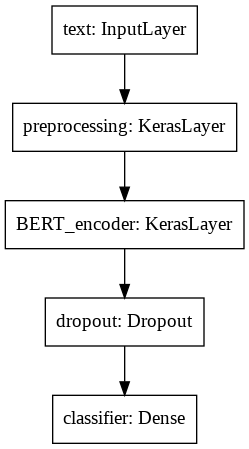

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
#steps_per_epoch = tf.data.experimental.cardinality(x_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

NameError: ignored